<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Data-prep" data-toc-modified-id="Data-prep-1">Data prep</a></span></li><li><span><a href="#Testing-Classifiers" data-toc-modified-id="Testing-Classifiers-2">Testing Classifiers</a></span><ul class="toc-item"><li><span><a href="#Decision-Tree-Classifier" data-toc-modified-id="Decision-Tree-Classifier-2.1">Decision Tree Classifier</a></span><ul class="toc-item"><li><span><a href="#Optimizing-tree-depth" data-toc-modified-id="Optimizing-tree-depth-2.1.1">Optimizing tree depth</a></span></li></ul></li><li><span><a href="#Gradient-Boosting-Classifier" data-toc-modified-id="Gradient-Boosting-Classifier-2.2">Gradient Boosting Classifier</a></span></li><li><span><a href="#Histogram-based-Gradient-Boosting-Classifier" data-toc-modified-id="Histogram-based-Gradient-Boosting-Classifier-2.3">Histogram-based Gradient Boosting Classifier</a></span></li></ul></li></ul></div>

In [67]:
# Imports 

import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from joblib import Parallel, delayed
from tqdm import tqdm

import sys
sys.path.append("/home/scottd/Dropbox/Other-Programming/SP500-Trading/data_wrangling/")
from data_wrangling import TickerData

# Data prep

In [2]:
# Data loading 
ticker_data = TickerData("/home/scottd/Dropbox/Other-Programming/SP500-Trading/data/")
ds = ticker_data.create_torch_dataset(t0=dt.time(19, 0), t1=dt.time(20, 55), N_classes=2)

Class value: tensor(False) 	 Instance count: tensor(52157)
Class value: tensor(True) 	 Instance count: tensor(51208)


Since sklearn doesn't need torch datasets we convert everything to plain old numpy arrays then split into training and testing sets:

In [16]:
# Code 
X = []
Y = []
ratios = []
for (x, y, r) in tqdm(ds):
    X.append(x.numpy().flatten()) #sklearn classifiers only accept 1D input so need to flatten here
    Y.append(y.item())
    ratios.append(r.item())
X, Y, ratios = map(np.array, [X, Y, ratios])
    
X_train, X_test, Y_train, Y_test, R_train, R_test = train_test_split(X, Y, ratios, shuffle=False, test_size=0.05)

print(
    "Percentage of expected buy in: \n Training set =", sum(Y_train) / len(Y_train), 
    "\n Test set =",  sum(Y_test) / len(Y_test)
)

100%|███████████████████████████████████████████████████████████████████████| 103365/103365 [00:00<00:00, 160048.05it/s]


Percentage of expected buy in: 
 Training set = 0.4980549105869893 
 Test set = 0.4451538015089959


Check the distribution of profit ratios in train/test sets to anticipate potential biases:

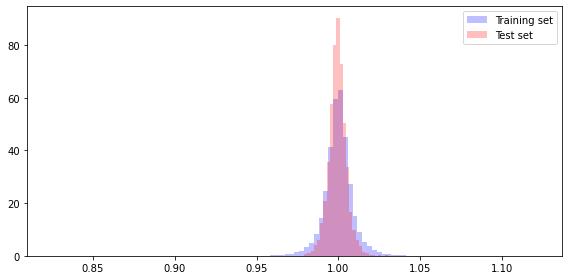

In [4]:
# Code 
fig, ax = plt.subplots(figsize=(8, 4))

kwargs = {"bins":100, "histtype":"bar", "alpha":0.25, "density":True}
ax.hist(R_train, color="b", label="Training set", **kwargs)
ax.hist(R_test, color="r", label="Test set", **kwargs)
ax.legend()

plt.tight_layout()

# Testing Classifiers

## Decision Tree Classifier

In [5]:
# Code 
from sklearn.tree import DecisionTreeClassifier

model = DecisionTreeClassifier(
    max_depth=10,
)
model.fit(X_train, Y_train)

DecisionTreeClassifier(max_depth=10)

In [6]:
Y_train_pred = model.predict(X_train)
print(classification_report(Y_train, Y_train_pred))

              precision    recall  f1-score   support

       False       0.70      0.72      0.71     49289
        True       0.71      0.68      0.69     48907

    accuracy                           0.70     98196
   macro avg       0.70      0.70      0.70     98196
weighted avg       0.70      0.70      0.70     98196



In [7]:
Y_test_pred = model.predict(X_test)
print(classification_report(Y_test, Y_test_pred))

              precision    recall  f1-score   support

       False       0.55      0.43      0.48      2868
        True       0.44      0.57      0.50      2301

    accuracy                           0.49      5169
   macro avg       0.50      0.50      0.49      5169
weighted avg       0.50      0.49      0.49      5169



Increasing max tree depth:

In [8]:
# Code 
from sklearn.tree import DecisionTreeClassifier

model = DecisionTreeClassifier(
    max_depth=100,
)
model.fit(X_train, Y_train)

DecisionTreeClassifier(max_depth=100)

In [9]:
Y_train_pred = model.predict(X_train)
print(classification_report(Y_train, Y_train_pred))

              precision    recall  f1-score   support

       False       1.00      1.00      1.00     49289
        True       1.00      1.00      1.00     48907

    accuracy                           1.00     98196
   macro avg       1.00      1.00      1.00     98196
weighted avg       1.00      1.00      1.00     98196



In [10]:
Y_test_pred = model.predict(X_test)
print(classification_report(Y_test, Y_test_pred))

              precision    recall  f1-score   support

       False       0.57      0.56      0.56      2868
        True       0.46      0.46      0.46      2301

    accuracy                           0.52      5169
   macro avg       0.51      0.51      0.51      5169
weighted avg       0.52      0.52      0.52      5169



### Optimizing tree depth

Parallelize fitting of trees with various depths then plot train and test set accuracies vs tree depth:

In [40]:
# Code 
depths = range(5, 100, 5)

def score_model(max_depth):
    model = DecisionTreeClassifier(max_depth=max_depth)
    model.fit(X_train, Y_train)
    return [
        accuracy_score(Y_train, model.predict(X_train)),
        accuracy_score(Y_test, model.predict(X_test)),
    ]

def plot_results(depths, scores):
    train_scores, test_scores = list(zip(*scores))
    fig, ax = plt.subplots(figsize=(8, 4))
    ax.scatter(depths, train_scores, label="Training Set")
    ax.scatter(depths, test_scores, label="Test Set")
    ax.set_xlabel("Tree depth")
    ax.set_ylabel("Classification Accuracy")
    ax.set_ylim(0, 1.05)
    ax.axhline([0.5], ls="--")
    ax.legend()
    plt.show()
        
# score_model(depths[0])
scores = Parallel(n_jobs=16)(delayed(score_model)(d) for d in depths) #Parallelize model training

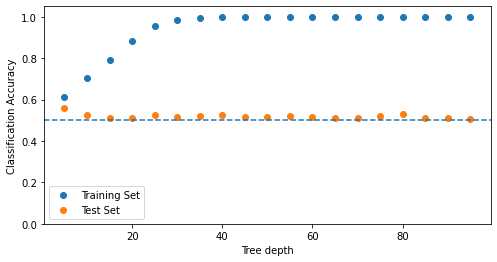

In [45]:
plot_results(depths, scores)

Above plot implies that very shallow trees might actually work best so try fine-tuning of shallow trees:

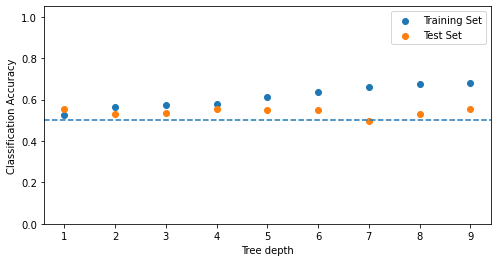

In [46]:
# Code 
depths = range(1, 10)
scores = Parallel(n_jobs=16)(delayed(score_model)(d) for d in depths) #Parallelize model training
plot_results(depths, scores)

From the above plot, it looks like a tree depth of 5 or 6 might be best. Let's dig into the performance of a model with max tree depth of 5:

In [57]:
# Code - train model 
best_tree_model = DecisionTreeClassifier(max_depth=5)
best_tree_model.fit(X_train, Y_train)

Y_train_pred = best_tree_model.predict(X_train)
print("Training set:\n", classification_report(Y_train, Y_train_pred))

Y_test_pred = best_tree_model.predict(X_test)
print("\nTest set:\n", classification_report(Y_test, Y_test_pred))

Training set:
               precision    recall  f1-score   support

       False       0.58      0.85      0.69     49289
        True       0.71      0.36      0.48     48907

    accuracy                           0.61     98196
   macro avg       0.64      0.61      0.58     98196
weighted avg       0.64      0.61      0.59     98196


Test set:
               precision    recall  f1-score   support

       False       0.57      0.78      0.66      2868
        True       0.49      0.25      0.33      2301

    accuracy                           0.55      5169
   macro avg       0.53      0.52      0.50      5169
weighted avg       0.53      0.55      0.51      5169



In [87]:
pd.Series(R_train[Y_train]).describe()

count    48907.000000
mean         1.006271
std          0.006474
min          1.000020
25%          1.001985
50%          1.004382
75%          1.008306
max          1.121536
dtype: float64

In [70]:
pd.Series(R_train[Y_train_pred]).describe()

count    25050.000000
mean         1.004661
std          0.009264
min          0.866457
25%          0.999358
50%          1.003567
75%          1.008899
max          1.117415
dtype: float64

In [88]:
pd.Series(R_test[Y_test]).describe()

count    2301.000000
mean        1.004110
std         0.004472
min         1.000036
25%         1.001343
50%         1.003031
75%         1.005484
max         1.106933
dtype: float64

In [69]:
pd.Series(R_test[Y_test_pred]).describe()

count    1204.000000
mean        0.999870
std         0.006292
min         0.978245
25%         0.996753
50%         0.999894
75%         1.002877
max         1.106933
dtype: float64

## Gradient Boosting Classifier

In [74]:
# Code 
from sklearn.ensemble import GradientBoostingClassifier

model = GradientBoostingClassifier(
    n_estimators=10,
    verbose=True, #Print progress info during training
)
model.fit(X_train, Y_train)

      Iter       Train Loss   Remaining Time 
         1           1.3768            2.92m
         2           1.3696            2.60m
         3           1.3596            2.26m
         4           1.3494            1.93m
         5           1.3424            1.61m
         6           1.3349            1.29m
         7           1.3260           57.87s
         8           1.3207           38.65s
         9           1.3137           19.32s
        10           1.3080            0.00s


GradientBoostingClassifier(n_estimators=10, verbose=True)

In [78]:
Y_train_pred = model.predict(X_train)
print(classification_report(Y_train, Y_train_pred))

              precision    recall  f1-score   support

       False       0.65      0.76      0.70     49289
        True       0.71      0.58      0.64     48907

    accuracy                           0.67     98196
   macro avg       0.68      0.67      0.67     98196
weighted avg       0.68      0.67      0.67     98196



In [79]:
Y_test_pred = model.predict(X_test)
print(classification_report(Y_test, Y_test_pred))

              precision    recall  f1-score   support

       False       0.56      0.24      0.33      2868
        True       0.45      0.77      0.56      2301

    accuracy                           0.47      5169
   macro avg       0.50      0.50      0.45      5169
weighted avg       0.51      0.47      0.44      5169



In [91]:
np.load("../data/data-array.npy").shape

(103365, 5, 391)

In [ ]:
len(ticker_data.cleaned_df.Date.unique())

In [89]:
ticker_data.create_data_array()

Loading cleaned data
Loading averaged data


  1%|▍                                                                             | 562/103365 [00:08<26:30, 64.65it/s]


KeyboardInterrupt: 

## Histogram-based Gradient Boosting Classifier

In [93]:
# Code 
from sklearn.ensemble import HistGradientBoostingClassifier

model = HistGradientBoostingClassifier(
    verbose=True, #Print progress info during training
)
model.fit(X_train, Y_train)

Binning 0.958 GB of training data: 10.347 s
Binning 0.106 GB of validation data: 0.068 s
Fitting gradient boosted rounds:
[1/100] 1 tree, 31 leaves, max depth = 14, train loss: 0.67496, val loss: 0.67593, in 0.132s
[2/100] 1 tree, 31 leaves, max depth = 13, train loss: 0.65922, val loss: 0.66072, in 0.130s
[3/100] 1 tree, 31 leaves, max depth = 12, train loss: 0.64596, val loss: 0.64784, in 0.133s
[4/100] 1 tree, 31 leaves, max depth = 15, train loss: 0.63429, val loss: 0.63620, in 0.131s
[5/100] 1 tree, 31 leaves, max depth = 11, train loss: 0.62412, val loss: 0.62635, in 0.132s
[6/100] 1 tree, 31 leaves, max depth = 12, train loss: 0.61520, val loss: 0.61746, in 0.137s
[7/100] 1 tree, 31 leaves, max depth = 14, train loss: 0.60751, val loss: 0.61000, in 0.134s
[8/100] 1 tree, 31 leaves, max depth = 11, train loss: 0.60051, val loss: 0.60331, in 0.133s
[9/100] 1 tree, 31 leaves, max depth = 10, train loss: 0.59445, val loss: 0.59745, in 0.130s
[10/100] 1 tree, 31 leaves, max depth = 1

HistGradientBoostingClassifier(verbose=True)

In [97]:
print(classification_report(Y_train, model.predict(X_train)))

              precision    recall  f1-score   support

       False       0.74      0.73      0.74     49289
        True       0.73      0.74      0.74     48907

    accuracy                           0.74     98196
   macro avg       0.74      0.74      0.74     98196
weighted avg       0.74      0.74      0.74     98196



In [98]:
print(classification_report(Y_test, model.predict(X_test)))

              precision    recall  f1-score   support

       False       0.55      0.33      0.41      2868
        True       0.44      0.65      0.53      2301

    accuracy                           0.48      5169
   macro avg       0.49      0.49      0.47      5169
weighted avg       0.50      0.48      0.46      5169

